## Problem Statement

To build and implement a multiclass classification deep neural network model to classify between Positive/Extremely Positive/Negative/Extremely Negative/Neutral sentiments

In [26]:
# Importing the data manipulation libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Data Preprocessing libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import re
import contractions
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Importing the model building libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, Bidirectional, LSTM, Dense, Dropout, GlobalMaxPooling1D, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from wordcloud import WordCloud
# Importing the evaluation libraries
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix

##   **Stage 1**:  Data Loading and Perform Exploratory Data Analysis

* Load the Dataset


In [12]:
# YOUR CODE HERE
train_data = pd.read_csv('/content/corona_nlp.csv',encoding='latin-1')  # Adjust path as needed

* Check for Missing Values

In [14]:
# YOUR CODE HERE
train_data.isnull().sum()

,0
UserName,0
ScreenName,0
Location,7564
TweetAt,0
OriginalTweet,0
Sentiment,0


* Visualize the sentiment column values


In [15]:
train_data['Sentiment'].value_counts()

,count
Sentiment,
Positive,9947
Negative,8717
Neutral,6692
Extremely Positive,5730
Extremely Negative,4911


* Visualize top 10 Countries that had the highest tweets using countplot (Tweet count vs Location)


In [16]:
train_data['Location'].value_counts().head(10)

,count
Location,
United States,483
London,456
"London, England",444
"New York, NY",339
"Washington, DC",333
United Kingdom,284
"Los Angeles, CA",249
India,224
USA,197


* Plotting Pie Chart for the Sentiments in percentage


<Axes: ylabel='count'>

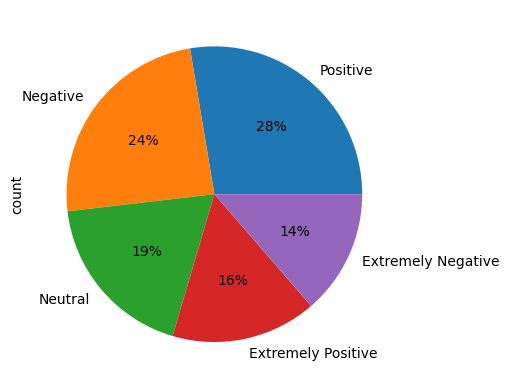

In [17]:
train_data['Sentiment'].value_counts().plot(kind='pie', autopct='%1.0f%%')

* WordCloud for the Tweets/Text

    * Visualize the most commonly used words in each sentiment using wordcloud
    * Refer to the following [link](https://medium.com/analytics-vidhya/word-cloud-a-text-visualization-tool-fb7348fbf502) for Word Cloud: A Text Visualization tool




Word Cloud for Sentiment: Positive


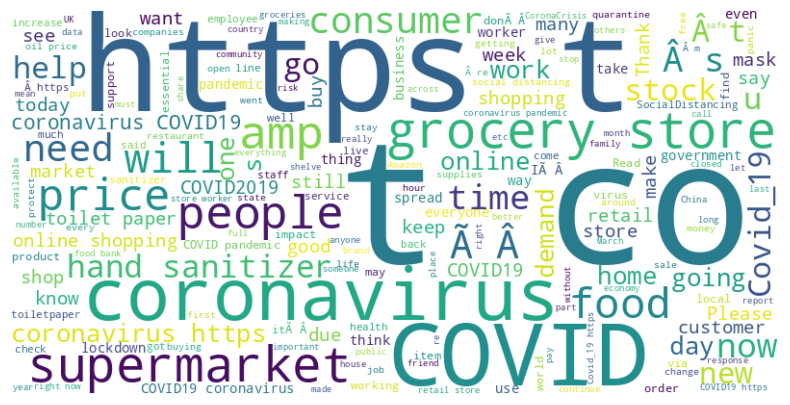

Word Cloud for Sentiment: Neutral


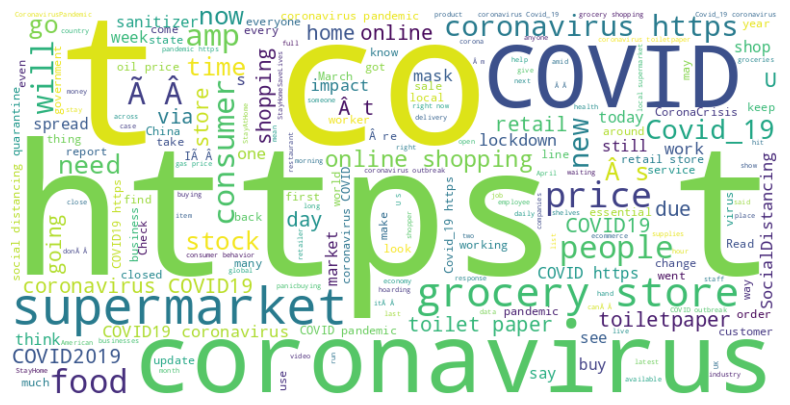

Word Cloud for Sentiment: Negative


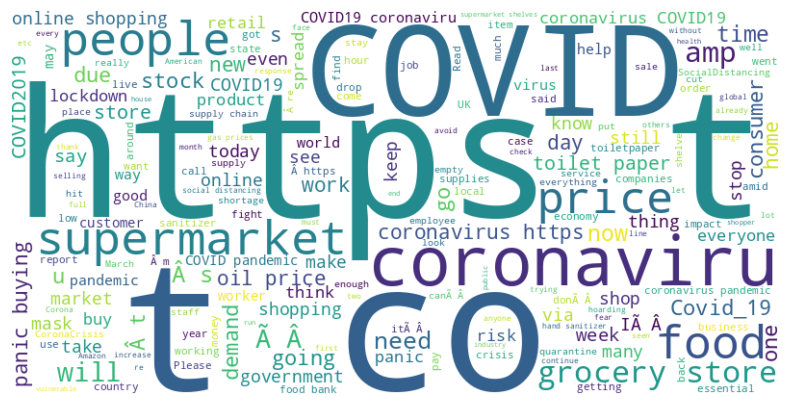

Word Cloud for Sentiment: Extremely Positive


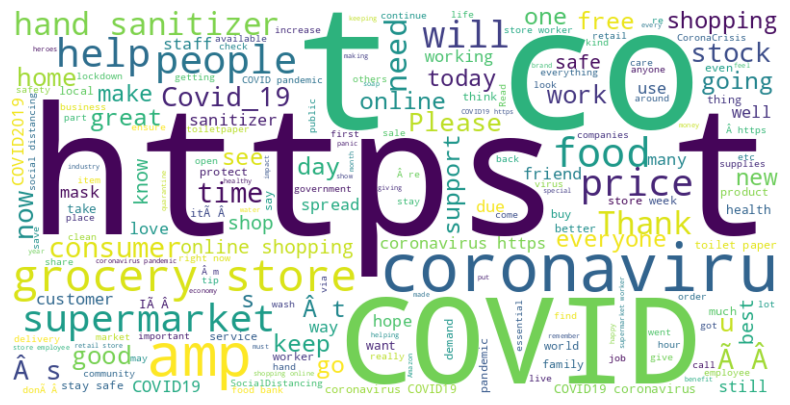

Word Cloud for Sentiment: Extremely Negative


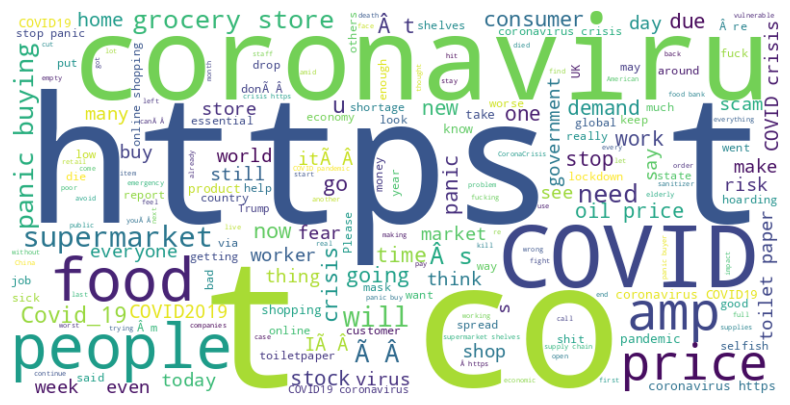

In [27]:
for sent in train_data['Sentiment'].unique():
    all_tweets = ' '.join(train_data[train_data['Sentiment'] == sent]['OriginalTweet'].to_list())
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_tweets)
    print(f"Word Cloud for Sentiment: {sent}")
    plt.figure(figsize=(10, 5))  # Set figure size
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")  # Turn off axis
    plt.show()

##   **Stage 2**: Data Pre-Processing  
####  Clean and Transform the data into a specified format


In [28]:
X = train_data['OriginalTweet']
y = train_data['Sentiment']
pd.set_option('display.max_colwidth', None)

In [29]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
X_test = test_data['OriginalTweet']

Text(0.5, 1.0, 'VALIDATION')

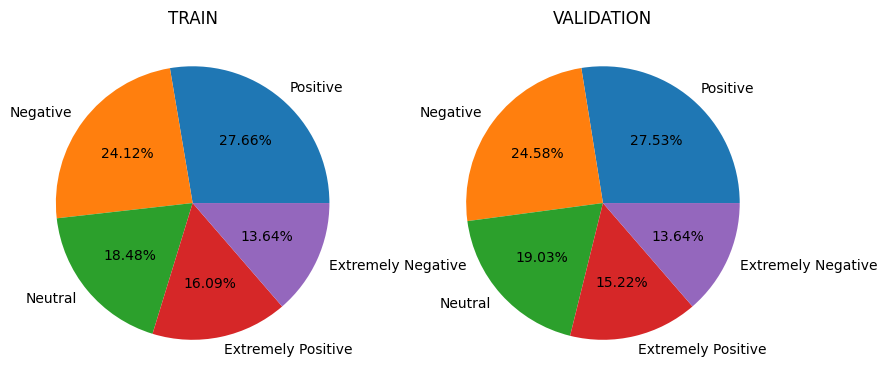

In [31]:
plt.rcParams['figure.figsize'] = (15, 10)

plt.subplot(1, 3, 1)
plt.pie(pd.Series(y_train).value_counts(), labels=pd.Series(y_train).value_counts().index, autopct='%1.2f%%')
plt.title("TRAIN")

plt.subplot(1, 3, 2)
plt.pie(pd.Series(y_val).value_counts(), labels=pd.Series(y_val).value_counts().index, autopct='%1.2f%%')
plt.title("VALIDATION")

In [32]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [33]:
def remove_unnecessary_elements(text):
    text = text.lower()
    text = re.sub(r'(covid[-_]?19|covid2019|covid[-_]?2019|corona[-_]?virus|corona|covid)', 'covid', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#', '', text)

    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\t', ' ', text)
    text = re.sub(r'\r', ' ', text)
    text = re.sub(r'â|â’', "'", text)
    text = re.sub(r'\x92|\xa0|\x85|\x95', '', text)
    text = contractions.fix(text)
    text = re.sub(r'[^\w\s]', ' ', text)

    return text

X_train = np.array([remove_unnecessary_elements(text) for text in X_train])
X_val = np.array([remove_unnecessary_elements(text) for text in X_val])
X_test = np.array([remove_unnecessary_elements(text) for text in X_test])

##   **Stage 3**: Build the Word Embeddings using pretrained Word2vec/Glove (Text Representation)


In [34]:
# tokenizing without limiting vocabulary size, to get word counts
tokenizer = Tokenizer(filters='')
tokenizer.fit_on_texts(X_train)

word_counts = len(tokenizer.word_index) + 1  # vocabulary size

print("Numbers of unique words present:", word_counts)

Numbers of unique words present: 38336


In [35]:
train_sequences = tokenizer.texts_to_sequences(X_train)

maxlen = max([len(seq) for seq in train_sequences])
print("Maximum length of all sequences:", maxlen)

padded_train_sequences = pad_sequences(train_sequences, maxlen=maxlen, padding='post')
print("Padded TRAINING Sequences Shape:", padded_train_sequences.shape)

Maximum length of all sequences: 65
Padded TRAINING Sequences Shape: (28797, 65)


In [36]:
longest_sequence_index = np.argmax([len(seq) for seq in train_sequences])

# Get the longest sequence and its corresponding original sentence
longest_sequence = train_sequences[longest_sequence_index]
longest_sentence = X_train[longest_sequence_index]

print(longest_sentence)

i want to go shopping i want to walk w o the thought i might get the covid virus i want a real hug i want to go eat at a dine in restaurant ohhh to be free w o the thought of that darn virus i want to go shopping for shoes i do not need just want to go shopping   no more online 


In [37]:
# For Validation set
val_sequences = tokenizer.texts_to_sequences(X_val)
padded_val_sequences = pad_sequences(val_sequences, maxlen=maxlen, padding='post')

print("Padded VALIDATION Sequences Shape:", padded_val_sequences.shape)

Padded VALIDATION Sequences Shape: (7200, 65)


In [38]:
# For test set
test_sequences = tokenizer.texts_to_sequences(X_test)
padded_test_sequences = pad_sequences(test_sequences, maxlen=maxlen, padding='post')

print("Padded TEST Sequences Shape:", padded_test_sequences.shape)

Padded TEST Sequences Shape: (8955, 65)


In [39]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [40]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2024-11-23 17:55:54--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-11-23 17:55:54--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-11-23 17:55:54--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [41]:
embedding_dim = 100
embedding_matrix = create_embedding_matrix('glove.6B.100d.txt', tokenizer.word_index, embedding_dim)

In [42]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print(f"Percent of vocabulary covered: {round(nonzero_elements/word_counts*100, 2)}%")

Percent of vocabulary covered: 66.61%


In [43]:
# Get the words that are not covered by GloVe
not_covered_words = []
for word, idx in tokenizer.word_index.items():
    if np.count_nonzero(embedding_matrix[idx]) == 0:  # If the embedding vector is all zeros
        not_covered_words.append(word)

# Print some of the words that are not covered
print(f"Total uncovered words: {len(not_covered_words)}")
print("Sample of uncovered words:", not_covered_words[:50])

Total uncovered words: 12798
Sample of uncovered words: ['covid', 'toiletpaper', 'iã', 'socialdistancing', 'itã', 'donã', 'covidcrisis', 'covidpandemic', 'covidoutbreak', 'canã', 'coviduk', 'stayhome', 'panicbuying', 'youã', 'stayathome', 'weã', 'covidupdate', 'stayhomesavelives', 'stophoarding', 'stoppanicbuying', 'staysafe', 'handsanitizer', 'theyã', 'quarantinelife', 'thereã', 'toiletpapercrisis', 'covidpocalypse', 'thatã', 'covidusa', 'toiletpaperpanic', 'wonã', 'covidlockdown', 'isnã', 'panicbuyinguk', 'doesnã', 'letã', 'hereã', 'covidindia', 'arenã', 'toiletpaperapocalypse', 'washyourhands', 'covidupdates', 'didnã', 'whatã', 'yã', 'onlineshopping', 'pricegouging', 'sanitiser', 'panicshopping', 'covidã']


In [44]:
print(padded_train_sequences)  # training feature
print(y_train)  # training target

[[  14  401   47 ...    0    0    0]
 [  75   11  126 ...    0    0    0]
 [ 731    3   73 ...    0    0    0]
 ...
 [  12  217    3 ...    0    0    0]
 [ 210   42   54 ...    0    0    0]
 [ 909  617 4130 ...    0    0    0]]
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]]


##   **Stage 4**: Build model

In [45]:
model = Sequential()

model.add(Embedding(word_counts,
                    embedding_dim,
                    weights=[embedding_matrix],
                    input_length=maxlen,
                    trainable=True))

model.add(SpatialDropout1D(0.3))

model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Bidirectional(LSTM(units=32, return_sequences=False)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(24, activation='relu', kernel_regularizer=l2(0.05)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.05)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(5, activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [46]:
model.build((padded_train_sequences.shape))

In [47]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (28797, 65, 100)            │       3,833,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ (28797, 65, 100)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (28797, 65, 128)            │          84,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (28797, 65, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (28797, 65, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (28797, 64)                 │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (28797, 64)                 │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (28797, 64)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (28797, 24)                 │           1,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (28797, 24)                 │              96 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (28797, 24)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (28797, 16)                 │             400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (28797, 16)                 │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (28797, 16)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (28797, 5)                  │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,962,269 (15.11 MB)

 Trainable params: 3,961,805 (15.11 MB)

 Non-trainable params: 464 (1.81 KB)

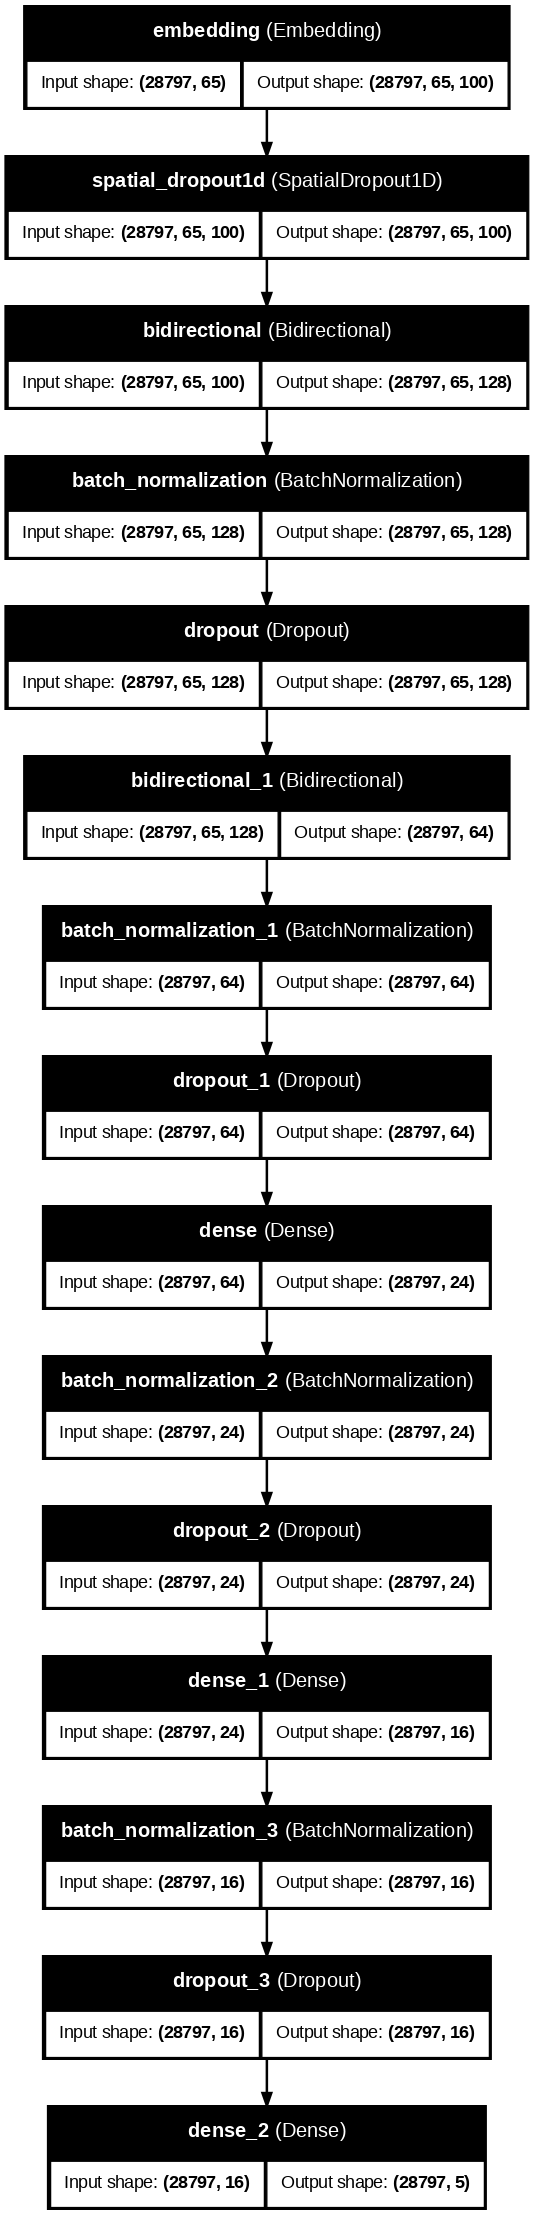

In [48]:
plot_model(model, show_shapes=True, show_layer_names=True, dpi=90)

In [49]:
# Assuming `y_train_original` holds the non-one-hot encoded original sentiment labels
y_train_original = np.argmax(y_train, axis=1)  # Converting one-hot encoded y_train back to label form

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_original), y=y_train_original)
class_weights = dict(enumerate(class_weights))

num_epochs = 200

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stop = EarlyStopping(monitor='val_loss', patience=10)

In [50]:
model.compile(loss = 'categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0002, clipnorm=1.0),
              metrics = ['accuracy'])

In [51]:
history = model.fit(padded_train_sequences,
                    y_train,
                    validation_data=(padded_val_sequences, y_val),
                    epochs=num_epochs,
                    class_weight=class_weights,
                    callbacks =[reduce_lr, early_stop, checkpoint],
                    batch_size=32,
                    verbose=1)

Epoch 1/200
898/900 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2200 - loss: 4.4977
Epoch 1: val_accuracy improved from -inf to 0.27153, saving model to best_model.keras
900/900 ━━━━━━━━━━━━━━━━━━━━ 40s 28ms/step - accuracy: 0.2200 - loss: 4.4962 - val_accuracy: 0.2715 - val_loss: 3.1271 - learning_rate: 2.0000e-04
Epoch 2/200
898/900 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2502 - loss: 2.9740
Epoch 2: val_accuracy improved from 0.27153 to 0.31250, saving model to best_model.keras
900/900 ━━━━━━━━━━━━━━━━━━━━ 25s 28ms/step - accuracy: 0.2503 - loss: 2.9733 - val_accuracy: 0.3125 - val_loss: 2.2445 - learning_rate: 2.0000e-04
Epoch 3/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2759 - loss: 2.1956
Epoch 3: val_accuracy improved from 0.31250 to 0.34903, saving model to best_model.keras
900/900 ━━━━━━━━━━━━━━━━━━━━ 26s 29ms/step - accuracy: 0.2759 - loss: 2.1955 - val_accuracy: 0.3490 - val_loss: 1.7748 - learning_rate: 2.0000e-04
Epoch 4/200
900/900 ━━━━━━━━━━━